In [1]:
import pandas as pd
from pyntcloud import PyntCloud
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import seaborn as sns
import numpy as np
import pyvista as pv
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import Precision, Accuracy, Recall
import open3d as o3d

from urb3d.segmentation.train import classes_df

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


device(type='cuda')

In [2]:
file_cloud = '../data/birmingham_blocks/birmingham_block_7_subsampled_train.ply'
pt = PyntCloud.from_file(file_cloud)

In [4]:
pt

PyntCloud
588246 points with 4 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 914.6486206054688, 313.8023376464844, 10.899514198303223
Other attributes:
	 comments: <class 'list'>

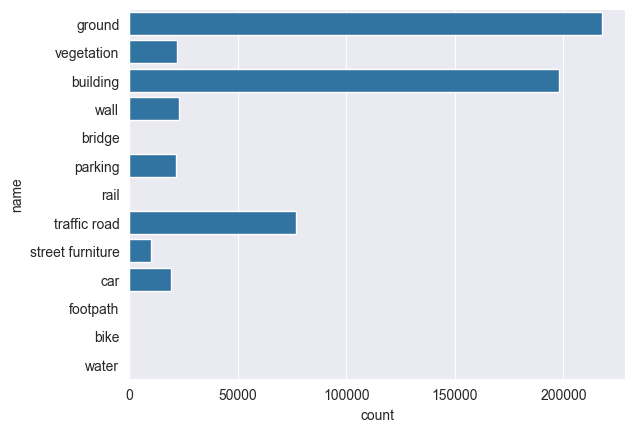

In [5]:
file_cloud = '../data/birmingham_blocks/birmingham_block_7_subsampled_train.ply'
pt = PyntCloud.from_file(file_cloud)
classes_count = pd.DataFrame(pt.points['scalar_class']).value_counts().reset_index().set_index('scalar_class')
classes_df = pd.DataFrame.from_dict({'scalar_class': np.arange(13), 'name': ['ground', 'vegetation', 'building', 'wall', 'bridge',
    'parking', 'rail', 'traffic road', 'street furniture', 'car', 'footpath', 'bike', 'water']}).set_index('scalar_class')
classes_df
counts = classes_df.join(classes_count).fillna(0)
sns.barplot(counts, y='name', x='count')
plt.show()

In [29]:

counts['weight'] = (1 / counts['count']).replace([np.inf, -np.inf], 1e-6)

In [30]:

counts['weight']

scalar_class
0.0     0.000005
1.0     0.000046
2.0     0.000005
3.0     0.000043
4.0     0.000001
5.0     0.000046
6.0     0.000001
7.0     0.000013
8.0     0.000099
9.0     0.000052
10.0    0.000001
11.0    0.000001
12.0    0.000001
Name: weight, dtype: float64

In [28]:
(1 / counts['count']).replace([np.inf, -np.inf], 1e-6)

scalar_class
0.0     0.000005
1.0     0.000046
2.0     0.000005
3.0     0.000043
4.0     0.000001
5.0     0.000046
6.0     0.000001
7.0     0.000013
8.0     0.000099
9.0     0.000052
10.0    0.000001
11.0    0.000001
12.0    0.000001
Name: count, dtype: float64

In [6]:
def min_max_standardize(coords):
    x = (coords.loc[:, 'x'] - np.min(coords.loc[:, 'x'])) / (np.max(coords.loc[:, 'x']) - np.min(coords.loc[:, 'x']))
    y = (coords.loc[:, 'y'] - np.min(coords.loc[:, 'y'])) / (np.max(coords.loc[:, 'y']) - np.min(coords.loc[:, 'y']))
    z = (coords.loc[:, 'z'] - np.min(coords.loc[:, 'z'])) / (np.max(coords.loc[:, 'z']) - np.min(coords.loc[:, 'z']))

    return x, y, z

In [7]:
from urb3d.segmentation.dataset import PointSampler
from urb3d.segmentation.segmentor import segmentation_loss, PointNetSegmentor

In [8]:
class PointCloudSegmentationDataset(Dataset):

    def __init__(self, point_cloud_path, subsample_size=None, point_sampler=None, ds_size=None):
        self.point_sampler = point_sampler
        self.pt = PyntCloud.from_file(point_cloud_path)
        self.ds_size = ds_size
        self.subsample_size = subsample_size if subsample_size else len(self.pt.points)
        x, y, z = min_max_standardize(self.pt.points[['x', 'y', 'z']])

        self.pt.points['x_norm'] = x
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z

        self.label = 'class' if 'class' in self.pt.points.columns else 'scalar_class'

    def __len__(self):
        # How to set the number of batches?
        return len(self.pt.points) // self.subsample_size if self.ds_size is None else self.ds_size

    def __getitem__(self, idx):
        # For now, a point cloud is sampled each time this function is called (it doesn't depend on idx)
        sampled_cloud = self.point_sampler(self.pt.points[['x_norm', 'y_norm', 'z_norm', self.label]])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        labels = torch.tensor(sampled_cloud[[self.label]].values, device=device, dtype=torch.long).flatten()
        return sampled_points.T, labels

In [9]:
segmentor = PointNetSegmentor(6)
logits, m3x3, m64x64 = segmentor.forward(torch.randn(10, 1024, 3).transpose(2, 1))

In [10]:
m3x3

tensor([[[ 0.9292, -0.1467,  0.3365],
         [ 0.4216,  1.0073,  0.1374],
         [-0.8984, -0.2184,  1.5467]],

        [[ 0.9464,  0.3503, -0.5908],
         [ 0.2367,  1.4359,  0.3926],
         [ 0.3061, -0.0466,  1.3560]],

        [[ 0.7965,  0.3181, -0.0070],
         [ 0.8230,  1.4577,  0.0735],
         [ 0.4060, -0.2196,  1.4472]],

        [[ 0.5274,  0.4230, -0.0865],
         [ 0.1373,  1.3695, -0.7927],
         [-0.5281, -0.1415,  1.0303]],

        [[ 1.0838,  0.4102,  0.0783],
         [-0.8810,  0.6889,  0.2926],
         [ 0.1957,  0.3453,  1.3724]],

        [[ 0.7221,  0.5765, -0.4711],
         [ 0.6713,  0.5174,  0.2551],
         [-0.3215,  0.1081,  1.6596]],

        [[ 1.0588, -0.0204,  0.5961],
         [ 0.4065,  1.1886, -0.1885],
         [-0.2573,  0.2655,  1.4298]],

        [[ 0.9799,  0.2805, -0.2533],
         [ 0.0141,  1.0167,  0.3186],
         [-0.2326, -0.6788,  1.8239]],

        [[ 1.0371, -0.0278, -0.2631],
         [ 0.0857,  1.3163,  0.189

In [11]:
logits.shape # (bs, # of classes, cld_s)

torch.Size([10, 6, 1024])

In [12]:
torch.argmax(logits, dim=1).shape

torch.Size([10, 1024])

In [36]:

torch.Tensor(counts['weight'])

tensor([4.5966e-06, 4.5756e-05, 5.0539e-06, 4.3354e-05, 1.0000e-06, 4.6019e-05,
        1.0000e-06, 1.2998e-05, 9.9030e-05, 5.2233e-05, 1.0000e-06, 1.0000e-06,
        1.0000e-06])

In [39]:
F.cross_entropy(logits, torch.randint(low=0, high=12, size=(10, 1024)), weight=torch.Tensor(counts['weight']))

RuntimeError: weight tensor should be defined either for all or no classes

In [14]:
segmentation_loss(logits, torch.randint(low=0, high=6, size=(10, 1024)), m3x3, m64x64)


tensor(2.1090, grad_fn=<AddBackward0>)

In [15]:
subsample_size = 1024 # as in original paper but ofc can be different
batch_size = 32

training_dataset = PointCloudSegmentationDataset('../data/birmingham_blocks/birmingham_block_7_subsampled_train.ply',
                                     subsample_size=subsample_size, point_sampler=PointSampler(subsample_size))
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = PointCloudSegmentationDataset('../data/birmingham_blocks/birmingham_block_7_subsampled_test.ply',
                                     subsample_size=subsample_size, point_sampler=PointSampler(subsample_size))
val_loader = DataLoader(validation_dataset, batch_size=batch_size)

model = PointNetSegmentor(classes=len(classes_df))

In [16]:
class PointCloudSegmentationDataset(Dataset):

    def __init__(self, point_cloud_path, subsample_size=None, point_sampler=None, ds_size=None):
        self.point_sampler = point_sampler
        self.pt: PyntCloud = PyntCloud.from_file(point_cloud_path)
        # self.pt.points['scalar_class'] = -1  ## temp
        self.ds_size = ds_size
        self.subsample_size = subsample_size if subsample_size else len(self.pt.points)
        x, y, z = min_max_standardize(self.pt.points[['x', 'y', 'z']])

        self.pt.points['x_norm'] = x
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z

        self.label = 'class' if 'class' in self.pt.points.columns else 'scalar_class'

    def get_pointcloud(self) -> PyntCloud:
        return self.pt

    def __len__(self):
        # How to set the number of batches?
        return len(self.pt.points) // self.subsample_size if self.ds_size is None else self.ds_size

    def __getitem__(self, idx):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # For now, a point cloud is sampled each time this function is called (it doesn't depend on idx)
        sampled_cloud = self.point_sampler(self.pt.points[['x_norm', 'y_norm', 'z_norm', self.label]])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        labels = torch.tensor(sampled_cloud[[self.label]].values, device=device, dtype=torch.long).flatten()
        return sampled_points.T, labels

In [17]:
experiment_name = "new_deal"
checkpoint_dir = Path(f"../models/{experiment_name}")
logger = TensorBoardLogger(save_dir=f"../models/{experiment_name}/tlogs", name=experiment_name)

max_epochs = 1

In [18]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
                                      monitor='val_loss', save_last=True)
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(max_epochs=max_epochs, fast_dev_run=False,
                     default_root_dir=checkpoint_dir, callbacks=[checkpoint_callback], logger=logger)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\kasia\PycharmProjects\urban-3d-reconstruction\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\kasia\PycharmProjects\urban-3d-reconstruction\models\new_deal\best_results exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type                | Params | Mode 
-----------------------------------------------------------
0  | precision | MulticlassPrecision | 0      | train
1  | recall    | MulticlassRecall    | 0      | train
2  | accuracy  | MulticlassAccuracy  | 0      | train
3  | transform | Transform           | 2.8 M  | train
4  | conv1     | Conv1d              | 557 K  | train
5  | conv2     | Conv1d              | 131 K  | train
6  | conv3     | Conv1d              | 32.9 K | train
7  | conv4     | Conv1d              | 1.7 K  | train
8  | bn1       | BatchNorm1d      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\kasia\PycharmProjects\urban-3d-reconstruction\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\kasia\PycharmProjects\urban-3d-reconstruction\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\kasia\PycharmProjects\urban-3d-reconstruction\venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [40]:
%load_ext tensorboard

In [43]:
%reload_ext tensorboard

In [45]:
%tensorboard --logdir ../models/pointnet_weighted


In [46]:

2+2

4

In [42]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import numpy as np

def timeit(tag, t):
    print("{}: {}s".format(tag, time() - t))
    return time()

def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


def index_points(points, idx):
    """

    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids


def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, 3]
        new_xyz: query points, [B, S, 3]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx


def sample_and_group(npoint, radius, nsample, xyz, points, returnfps=False):
    """
    Input:
        npoint:
        radius:
        nsample:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, npoint, nsample, 3]
        new_points: sampled points data, [B, npoint, nsample, 3+D]
    """
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
    new_xyz = index_points(xyz, fps_idx)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm
    if returnfps:
        return new_xyz, new_points, grouped_xyz, fps_idx
    else:
        return new_xyz, new_points


def sample_and_group_all(xyz, points):
    """
    Input:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, 3]
        new_points: sampled points data, [B, 1, N, 3+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C).to(device)
    grouped_xyz = xyz.view(B, 1, N, C)
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points


class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points


class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: input points position data, [B, C, N]
            xyz2: sampled input points position data, [B, C, S]
            points1: input points data, [B, D, N]
            points2: input points data, [B, D, S]
        Return:
            new_points: upsampled points data, [B, D', N]
        """
        xyz1 = xyz1.permute(0, 2, 1)
        xyz2 = xyz2.permute(0, 2, 1)

        points2 = points2.permute(0, 2, 1)
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, N, 1)
        else:
            dists = square_distance(xyz1, xyz2)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # [B, N, 3]

            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm
            interpolated_points = torch.sum(index_points(points2, idx) * weight.view(B, N, 3, 1), dim=2)

        if points1 is not None:
            points1 = points1.permute(0, 2, 1)
            new_points = torch.cat([points1, interpolated_points], dim=-1)
        else:
            new_points = interpolated_points

        new_points = new_points.permute(0, 2, 1)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        return new_points


In [80]:
class PointNetPP(pl.LightningModule):
    def __init__(self, classes=13):
        super().__init__()
        self.precision = Precision(task="multiclass", average='macro', num_classes=classes)
        self.recall = Recall(task="multiclass", average='macro', num_classes=classes)
        self.accuracy = Accuracy(task="multiclass", num_classes=classes)
        self.sa1 = PointNetSetAbstraction(1024, 0.1, 32, 3 + 3, [32, 32, 64], False)
        self.sa2 = PointNetSetAbstraction(256, 0.2, 32, 64 + 3, [64, 64, 128], False)
        self.sa3 = PointNetSetAbstraction(64, 0.4, 32, 128 + 3, [128, 128, 256], False)
        self.sa4 = PointNetSetAbstraction(16, 0.8, 32, 256 + 3, [256, 256, 512], False)
        self.fp4 = PointNetFeaturePropagation(768, [256, 256])
        self.fp3 = PointNetFeaturePropagation(384, [256, 256])
        self.fp2 = PointNetFeaturePropagation(320, [256, 128])
        self.fp1 = PointNetFeaturePropagation(128, [128, 128, 128])
        self.conv1 = nn.Conv1d(128, 128, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(128, classes, 1)

    def forward(self, xyz):
        l0_points = xyz
        l0_xyz = xyz[:,:3,:]

        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        l4_xyz, l4_points = self.sa4(l3_xyz, l3_points)

        l3_points = self.fp4(l3_xyz, l4_xyz, l3_points, l4_points)
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, None, l1_points)

        x = self.drop1(F.relu(self.bn1(self.conv1(l0_points))))
        x = self.conv2(x)
        x = F.log_softmax(x, dim=1)
        x = x.permute(0, 2, 1)
        return x, l4_points

    def training_step(self, batch, batch_idx):
        x, y = batch
        seg_pred, trans_feat = self(x)
        seg_pred = seg_pred.contiguous().view(-1, 13)

        predictions = y.view(-1, 1)[:, 0]
        loss = segmentation_loss(seg_pred, y, trans_feat)

        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_accuracy', self.accuracy(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_precision', self.precision(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_recall', self.recall(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        seg_pred, trans_feat = self(x)
        seg_pred = seg_pred.contiguous().view(-1, 13)

        predictions = y.view(-1, 1)[:, 0]
        loss = segmentation_loss(seg_pred, y, trans_feat)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_accuracy', self.accuracy(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_precision', self.precision(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_recall', self.recall(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions, _= self(x)
        return torch.argmax(predictions, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


def segmentation_loss(outputs, target, trans_feat):
    total_loss = F.nll_loss(outputs, target)
    return total_loss

In [91]:
mini_batch = train_loader.__iter__().__next__()[0]

In [79]:
model = PointNetPP(13)
xyz = torch.rand(6, 9, 2048)
res = model(xyz)

RuntimeError: Given groups=1, weight of size [32, 6, 1, 1], expected input[6, 12, 32, 1024] to have 6 channels, but got 12 channels instead

In [55]:
xyz.shape

torch.Size([6, 9, 2048])

In [92]:
mini_batch.shape

torch.Size([32, 3, 1024])

In [83]:
model.cuda()
result = model(mini_batch)

In [84]:
mini_batch[1].shape

torch.Size([3, 1024])

In [87]:
mini_batch[1].view(-1, 1)[:, 0].shape

torch.Size([3072])

In [73]:
sa_test = PointNetSetAbstraction(1024, 0.1, 32, 6, [32, 32, 64], False)
sa_test.cuda()

PointNetSetAbstraction(
  (mlp_convs): ModuleList(
    (0): Conv2d(6, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp_bns): ModuleList(
    (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [51]:
l0_points = mini_batch
l0_xyz = mini_batch

l1_xyz, l1_points = (sa_test(l0_xyz, l0_points))

In [90]:

mini_batch[1].shape

torch.Size([3, 1024])

In [89]:
F.nll_loss(mini_batch,mini_batch[1] )

TypeError: nll_loss_nd(): argument 'input' (position 1) must be Tensor, not int

In [69]:
mini_batch[1].shape

torch.Size([3, 1024])

In [11]:
model = PointNetPP(13)

In [58]:
experiment_name = "pointnetpp"
checkpoint_dir = Path(f"../models/{experiment_name}")
logger = TensorBoardLogger(save_dir=f"../models/{experiment_name}/tlogs", name=experiment_name)

max_epochs = 1
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / 'best_results',
                                                   filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
                                                   monitor='val_loss', save_last=True)

trainer = pl.Trainer(max_epochs=max_epochs, fast_dev_run=False,
                     default_root_dir=checkpoint_dir, callbacks=[checkpoint_callback], logger=logger)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type                       | Params | Mode 
------------------------------------------------------------------
0  | precision | MulticlassPrecision        | 0      | train
1  | recall    | MulticlassRecall           | 0      | train
2  | accuracy  | MulticlassAccuracy         | 0      | train
3  | sa1       | PointNetSetAbstraction     | 3.6 K  | train
4  | sa2       | PointNetSetAbstraction     | 17.3 K | train
5  | sa3       | PointNetSetAbstraction     | 67.5 K | train
6  | sa4       | PointNetSetAbstraction     | 265 K  | train
7  | fp4       | PointNetFeaturePropagation | 263 K  | train
8  | fp3       | PointNetFeaturePropagation | 165 K  | train
9  | fp2       | PointNetFeaturePropagation | 115 K  | train
10 | fp1       | PointNetFeaturePropagation | 50.3 K | train
11 | conv1     | Conv1d                   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\kasia\PycharmProjects\urban-3d-reconstruction\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


ValueError: Expected input batch_size (32768) to match target batch_size (32).

NameError: name 'PointNetSetAbstraction' is not defined